In [2]:
# this sets up basic packages
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.cosmology.units as cu
from scipy.stats.mstats import mquantiles

# this sets up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# this sets up astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky, Distance
from astropy.cosmology import Planck15 as cosmo
from astropy.table import Table, unique

from regions import Regions, CircleSkyRegion

In [3]:
coords_df = pd.read_csv('/Users/ngbinh/Downloads/rafael_data/coordinates.txt', delimiter=' ')
coords_df = coords_df.rename(columns={"Id": "id"})

In [4]:
info_df = pd.read_csv('/Users/ngbinh/Downloads/rafael_data/CIGALE_COSMOSWEB_v3.1.0.dat', delimiter=' ')

In [5]:
# this creates a mega DataFrame 
df = pd.merge(coords_df, info_df, on="id", how="left")

In [6]:
ras = df['alpha'].values
decs = df['delta'].values
redshifts = df['best.universe.redshift'].values

# this creates a SkyCoord object of all the objects' RAs and Decs, so we can loop through them later.
all_objects = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)

In [7]:
### from the arrays of RA and Dec, pick a random pair of RA and Dec and find their neighbors within a specified
### aperture. do this 1000 times, then save the number of neighbors from each time into an array.

# this creates an array of search radii
radii_array = np.arange(1, 16, 2)

# this creates an empty list of neighbor numbers for each iteration over search radii to add into
all_numbers_of_neighbors = []

# this is the loop that goes through each search radius
for search_radius in radii_array:

    # this creates an empty array to save the number of neighbors for each run with each search radius
    number_of_neighbors = np.zeros(1000)
        
    # this for-loop is to run the code 1000 times
    for i in range(1000):
        # use np.random.uniform to find a random RA and Dec within our given boundaries
        random_ras = np.random.uniform(np.min(ras), np.max(ras))
        random_decs = np.random.uniform(np.min(decs), np.max(decs))
        
        # turn the randomly generated RA and Dec into coords to find neighbors for
        random_coords = SkyCoord(ra=random_ras*u.degree, dec=random_decs*u.degree)
        
        # now, we search for all the neighbors of these random coordinates, within a given distance
        d2d = random_coords.separation(all_objects)
        catalog_mask = d2d < search_radius*u.arcsec
    
        # now, we apply a new criterion: photometric redshift 
        neighbor_ras = ras[catalog_mask]
        neighbor_zs = redshifts[catalog_mask]
        
        # final selection of galaxies, which should have redshift within 3 and 4
        final_ras = neighbor_ras[(neighbor_zs >= 3) & (neighbor_zs <= 4)]
    
        # this saves the number of neighbors identified in each run into the array we've made above
        number_of_neighbors[i] = np.size(final_ras)

    print(search_radius)
    
    all_numbers_of_neighbors.append(number_of_neighbors)

1
3
5
7
9
11
13
15


In [8]:
all_numbers_of_neighbors = np.array(all_numbers_of_neighbors, dtype='object')

In [9]:
all_radii_means = np.zeros(np.size(radii_array))
all_radii_percentile = np.zeros(np.size(radii_array))

for x in range(np.size(radii_array)):
    case = all_numbers_of_neighbors[x]
#    all_radii_means[x] = np.mean(case)
    #all_radii_percentile[x] = 
    print(mquantiles(case, alphap=0.16, betap=0.14, axis=0))

[0.0 0.0 0.0]
[0.0 0.0 0.0]
[0.0 0.0 0.0]
[0.0 0.0 1.0]
[0.0 0.0 1.0]
[0.0 0.0 2.0]
[0.0 0.0 3.0]
[0.0 0.0 4.0]


In [10]:
### now, look through the 9 QGs and their identified neighbors. do the same thing as we did earlier.
host_info = pd.read_csv('basic_data.txt', delimiter=' ', names=['name', 'RA', 'Dec', 'spec_z'])
host_ra_arr = host_info['RA'].values
host_dec_arr = host_info['Dec'].values
how_many_galaxies = np.size(host_ra_arr)

tentative = pd.read_csv('potential_neighbors.txt', sep='\t')

In [11]:
# this creates an empty list of real neighbor numbers for each iteration over search radii to add into
all_numbers_of_real_neighbors = []

# this loops through each search radius
for search_radius in radii_array:

    # this creates an empty array to save the number of neighbors for each run with each search radius
    number_of_real_neighbors = np.zeros(how_many_galaxies)
    
    # this loops through the 9 QGs
    for galaxy_number in range(how_many_galaxies):
        # this retrieves the RA and Dec of each QG
        host_ra = host_ra_arr[galaxy_number]
        host_dec = host_dec_arr[galaxy_number]    
    
        tentative_ra = tentative[tentative['host_ra']==host_ra]['ra'].values
        tentative_dec = tentative[tentative['host_ra']==host_ra]['dec'].values
    
        host_coords = SkyCoord(ra=host_ra*u.degree, dec=host_dec*u.degree)
        tentative_objects = SkyCoord(ra=tentative_ra*u.degree, dec=tentative_dec*u.degree)

        # now, we search for all the neighbors of these random coordinates, within a given distance
        d2d = host_coords.separation(tentative_objects)
        catalog_mask = d2d < search_radius*u.arcsec
        neighbor_ras = tentative_ra[catalog_mask]
    
        # this saves the number of neighbors identified in each run into the array we've made above
        number_of_real_neighbors[galaxy_number] = np.size(neighbor_ras)

    all_numbers_of_real_neighbors.append(number_of_real_neighbors)

In [12]:
all_numbers_of_real_neighbors = np.array(all_numbers_of_real_neighbors, dtype='object')

In [13]:
real_raw_data = np.zeros(np.size(radii_array))
real_radii_means = np.zeros(np.size(radii_array))
real_radii_stdev = np.zeros(np.size(radii_array))

for y in range(np.size(radii_array)):
    case = all_numbers_of_real_neighbors[y]
    real_raw_data[y] = np.sum(case)
    real_radii_means[y] = np.mean(case)
    real_radii_stdev[y] = np.std(case)

Text(0.5, 1.0, 'average number of neighbors over different search radii')

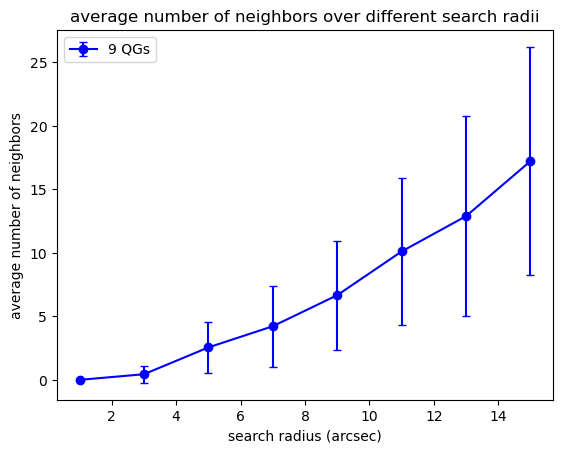

In [14]:
#plt.errorbar(radii_array, all_radii_means, all_radii_stdev, fmt='-o', capsize=3, color='red', label='1000 runs', zorder=1)
plt.errorbar(radii_array, real_radii_means, real_radii_stdev, fmt='-o', capsize=3, color='blue', label='9 QGs')
plt.legend()
plt.xlabel('search radius (arcsec)')
plt.ylabel('average number of neighbors')
plt.title('average number of neighbors over different search radii')